# Chapter 7 - Moving Beyond Linearity

[7.1 Polynomial Regression](#7.1-Polynomial-Regression)

[7.2 Step Functions](#7.2-Step-Functions)

[7.3 Basis Functions](#7.3-Basis-Functions)

[7.4 Regression Splines](#7.4-Regression-Splines)

In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

from plot_lm import plot_lm

import re

%matplotlib inline
plt.style.use('seaborn-white')

In [3]:
df_wage = pd.read_csv('Data/Wage.csv')
df_wage.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
for col_name in df_wage.columns:
    if df_wage[col_name].dtype == 'object':
        # get list of categories
        cat_list = np.sort(df_wage[col_name].unique())
        # create a categorical dtype that is ordered for the columns that makes sense
        cat_dtype = CategoricalDtype(cat_list, ordered=True if col_name in ['education', 'health'] else False)        
        df_wage[col_name] = df_wage[col_name].astype(cat_dtype)
        # strip '#. ' from the categories names
        df_wage[col_name].cat.categories  = [re.sub(r"\d+.\s+", "", cat) for cat in cat_list]
        print(f'{col_name}: {df_wage[col_name].cat.categories.values}')
df_wage.head(3)

sex: ['Male']
maritl: ['Never Married' 'Married' 'Widowed' 'Divorced' 'Separated']
race: ['White' 'Black' 'Asian' 'Other']
education: ['< HS Grad' 'HS Grad' 'Some College' 'College Grad' 'Advanced Degree']
region: ['Middle Atlantic']
jobclass: ['Industrial' 'Information']
health: ['<=Good' '>=Very Good']
health_ins: ['Yes' 'No']


,ID,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,Male,Never Married,White,< HS Grad,Middle Atlantic,Industrial,<=Good,No,4.318063,75.043154
1,86582,2004,24,Male,Never Married,White,College Grad,Middle Atlantic,Information,>=Very Good,No,4.255273,70.476020
2,161300,2003,45,Male,Married,White,Some College,Middle Atlantic,Industrial,<=Good,Yes,4.875061,130.982177


In [4]:
df_wage.describe()

,ID,year,age,logwage,wage
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,218883.373000,2005.791000,42.414667,4.653905,111.703608
std,145654.072587,2.026167,11.542406,0.351753,41.728595
min,7373.000000,2003.000000,18.000000,3.000000,20.085537
25%,85622.250000,2004.000000,33.750000,4.447158,85.383940
50%,228799.500000,2006.000000,42.000000,4.653213,104.921507
75%,374759.500000,2008.000000,51.000000,4.857332,128.680488
max,453870.000000,2009.000000,80.000000,5.763128,318.342430


In [5]:
df_wage.describe(include='category')

,sex,maritl,race,education,region,jobclass,health,health_ins
count,3000,3000,3000,3000,3000,3000,3000,3000
unique,1,5,4,5,1,2,2,2
top,Male,Married,White,HS Grad,Middle Atlantic,Industrial,>=Very Good,Yes
freq,3000,2074,2480,971,3000,1544,2142,2083


## 7.1 Polynomial Regression

#### FIGURE 7.1

In [76]:
# polynomial regression
linear = skl_lm.LinearRegression()
poly = PolynomialFeatures(4)

X = df_wage['age'].values.reshape(-1, 1)
y = df_wage['wage']

X_poly = poly.fit_transform(X)
linear.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [77]:
# logistic regression
df_logistic_wage = pd.DataFrame({'age': df_wage['age'].values, 'large_wage': df_wage['wage'].values > 250}, 
                                columns=['age', 'large_wage'])
df_logistic_wage.large_wage = df_logistic_wage.large_wage.astype(int)

X = df_logistic_wage['age'].values.reshape(-1, 1).astype(float)
y = df_logistic_wage['large_wage']

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('polynomial', PolynomialFeatures(4)),
                       ('logistic', skl_lm.LogisticRegression(C=1e10))])
# Fit all the transforms one after the other and transform the data, then fit the transformed data using the final estimator.
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomial', PolynomialFeatures(degree=4, include_bias=True, interaction_only=False)), ('logistic', LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

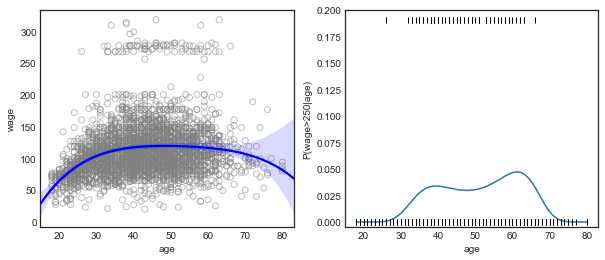

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.scatter(df_wage.age, df_wage.wage, facecolors='None', edgecolors='grey', alpha=.5)
# seaborn uses np.polyfit to fit a polynomial of order 4 to the data, basically the same we did with sklearn
sns.regplot(df_wage.age, df_wage.wage, ci=100, label='Degree 4', order=4, scatter=False, color='blue', ax=ax1)

age_range = np.linspace(df_logistic_wage.age.min(), df_logistic_wage.age.max(), 1000).reshape((-1, 1))
# Apply transforms to the data, and predict with the final estimator
predictions = pipe.predict_proba(age_range)[:, 1]
# probability of wage > 250 given age
ax2.plot(age_range, predictions)
ax2.set_ylim(ymin=-0.005, ymax=0.2)
# rug plot
ax2.plot(X, y*0.19, '|', color='k')
ax2.set_xlabel('age')
ax2.set_ylabel('P(wage>250|age)');

## 7.2 Step Functions

#### FIGURE 7.2

In [81]:
# fit a stepwise function to wage data. Use four bins like in Figure 7.2

In [82]:
num_bins = 4

df_step = pd.DataFrame(pd.cut(df_wage.age, num_bins))
df_step = pd.get_dummies(df_step)
df_step['wage'] = df_wage.wage
df_step['age'] = df_wage.age
df_step.head(3)

,"age_(17.938, 33.5]","age_(33.5, 49.0]","age_(49.0, 64.5]","age_(64.5, 80.0]",wage,age
0,1,0,0,0,75.043154,18
1,1,0,0,0,70.476020,24
2,0,1,0,0,130.982177,45


In [83]:
# linear regression
linear = skl_lm.LinearRegression()

X = df_step[df_step.columns.difference(['wage', 'age'])]
y = df_step['wage']

linear.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [84]:
# logistic regression
df_logistic_step = df_step.copy()
df_logistic_step['large_wage'] = (df_logistic_step['wage'].values > 250).astype(int)

X = df_logistic_step[df_step.columns.difference(['wage', 'age', 'large_wage'])]
y = df_logistic_step['large_wage']

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('logistic', skl_lm.LogisticRegression(C=1e10))])
# Fit all the transforms one after the other and transform the data, then fit the transformed data using the final estimator.
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

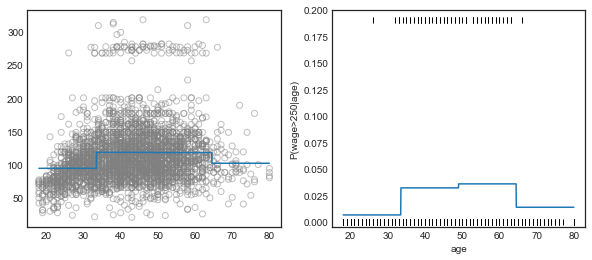

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.scatter(df_step.age, df_step.wage, facecolors='None', edgecolors='grey', alpha=.5)

age_range = np.linspace(df_step.age.min(), df_step.age.max(), 1000)
age_range_dummies = pd.get_dummies(pd.cut(age_range, num_bins))
predictions = linear.predict(age_range_dummies)
ax1.plot(age_range, predictions)

# Apply transforms to the data, and predict with the final estimator
predictions = pipe.predict_proba(age_range_dummies)[:, 1]
# probability of wage > 250 given age
ax2.plot(age_range, predictions)
ax2.set_ylim(ymin=-0.005, ymax=0.2)
# rug plot
ax2.plot(df_step.age, y*0.19, '|', color='k')
ax2.set_xlabel('age')
ax2.set_ylabel('P(wage>250|age)');

## 7.3 Basis Functions

## 7.4 Regression Splines

#### FIGURE 7.5

In [214]:
# use patsy to generate the (natural) spline basis.
# scipy.interpolate has splines, but you can only fit them, not get the basis
X = df_wage['age'].values.reshape(-1, 1)
y = df_wage['wage']
knots = np.percentile(X, [25, 50, 75])
spline_basis = dmatrix("cr(x, knots=knots)", {"x": X, 'knots': knots}, return_type='dataframe')

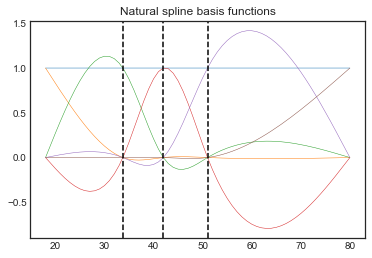

In [218]:
spline_basis_plot = dmatrix("cr(x, knots=knots)", {"x": np.sort(X, axis=0), 'knots': knots}, return_type='dataframe')
plt.plot(np.sort(X, axis=0), spline_basis_plot.values, '-', linewidth=0.5)
for knot in knots:
    plt.axvline(knot, ls='--', color='k')
plt.title('Natural spline basis functions');

In [228]:
# linear regression
linear = skl_lm.LinearRegression()
linear.fit(spline_basis, y)

# logistic regression
X = spline_basis.values
y_log = (df_wage['wage'].values > 250).astype(int)

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('logistic', skl_lm.LogisticRegression(C=1e10))])
# Fit all the transforms one after the other and transform the data, then fit the transformed data using the final estimator.
pipe.fit(X, y_log)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

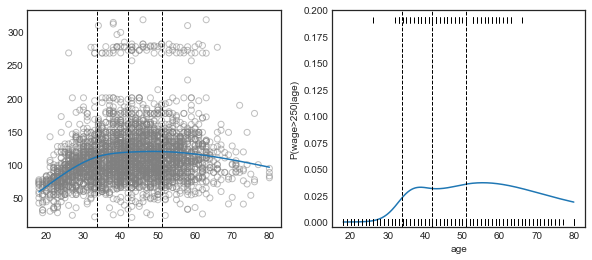

In [235]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.scatter(df_wage.age, df_wage.wage, facecolors='None', edgecolors='grey', alpha=.5)

age_range = np.linspace(df_wage.age.min(), df_wage.age.max(), 1000)
age_spline_basis = dmatrix("cr(age_range, knots=knots)", {"age_range": age_range, 'knots': knots}, return_type='dataframe')
predictions = linear.predict(age_spline_basis.values)
ax1.plot(age_range, predictions)

# Apply transforms to the data, and predict with the final estimator
predictions = pipe.predict_proba(age_spline_basis)[:, 1]
# probability of wage > 250 given age
ax2.plot(age_range, predictions)
ax2.set_ylim(ymin=-0.005, ymax=0.2)
# rug plot
ax2.plot(df_wage.age, y_log*0.19, '|', color='k')
ax2.set_xlabel('age')
ax2.set_ylabel('P(wage>250|age)')

for ax in (ax1, ax2):
    for knot in knots:
        ax.axvline(knot, ls='--', color='k', linewidth=1)

## 7.5 Smoothing Splines